# Reasoning Direction

This notebook aims to estimate the "reasoning" direction within the LLM activation space.
We're basing this approach on the methodology used to find the "refusal" direction, but with a key difference:

- **Refusal paper approach**: Used 1 LLM with 2 types of prompts (harmful vs harmless)
- **Our approach**: Use 2 models (original vs reasoning-tuned) with the same prompts (GSM8K math problems)

We'll collect activations from both models, calculate the difference (reasoning direction),
and then test if adding this direction to the reasoning/non-reasoning model enhances its reasoning capabilities.

This notebook adapts methodology from the orthogonal direction analysis demonstrated in:
https://huggingface.co/failspy/llama-3-70B-Instruct-abliterated/blob/main/ortho_cookbook.ipynb

In [1]:
# Setup and imports
!pip install transformers transformers_stream_generator tiktoken transformer_lens einops jaxtyping colorama scikit-learn datasets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 76.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 KB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 KB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.1/468.1 KB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 79.2 M

In [1]:
import os
import torch
import functools
import einops
import requests
import pandas as pd
import io
import textwrap
import gc
import transformers
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import Tensor
from typing import List, Callable, Dict, Tuple, Optional, Union
from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer, AutoModelForCausalLM
from jaxtyping import Float, Int
from colorama import Fore
from huggingface_hub import snapshot_download

# We turn off automatic differentiation to save GPU memory
torch.set_grad_enabled(False)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-06 20:40:53.879368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741293653.955937   13318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741293653.977928   13318 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load models

We'll load both the original model and the reasoning-tuned model using HookedTransformer.
If using a HuggingFace model, we can download it directly. If using a local model, make sure it's 
in the correct directory structure.

In [2]:
# Define model paths - adjust these based on your models
MODEL_PATH_ORIGINAL = "meta-llama/Llama-3.1-8B-Instruct"  # Non-reasoning model
MODEL_PATH_REASONING = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"  # Reasoning model

### Load both models

In [3]:
# Login to HuggingFace
from huggingface_hub import login

# Replace with your HF token from https://huggingface.co/settings/tokens
login(token="") 

In [4]:
# Load the original (non-reasoning) model
model_original = HookedTransformer.from_pretrained_no_processing(
    MODEL_PATH_ORIGINAL,
    dtype=torch.bfloat16,
    default_padding_side='left'
)
model_original.tokenizer.padding_side = 'left'
model_original.tokenizer.pad_token = model_original.tokenizer.eos_token

print(f"Loaded non-reasoning model {MODEL_PATH_ORIGINAL}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B-Instruct into HookedTransformer
Loaded non-reasoning model meta-llama/Llama-3.1-8B-Instruct


#### Optional: Download the reasoning model if needed
This step can be skipped if you already have the models locally

In [5]:
# Uncomment this to download the reasoning model
model_path = snapshot_download(
    repo_id=MODEL_PATH_REASONING,
    local_dir=MODEL_PATH_ORIGINAL,
    local_dir_use_symlinks=False
)

/home/ubuntu/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:834: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Fetching 11 files: 100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


In [7]:
# Load the reasoning model
model_reasoning = HookedTransformer.from_pretrained_no_processing(
    MODEL_PATH_ORIGINAL,
    local_files_only=True,  # Set to True if using local models
    dtype=torch.bfloat16,
    default_padding_side='left'
)
model_reasoning.tokenizer.padding_side = 'left'
model_reasoning.tokenizer.pad_token = model_reasoning.tokenizer.eos_token

print(f"Loaded reasoning model {MODEL_PATH_REASONING}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B-Instruct into HookedTransformer
Loaded reasoning model deepseek-ai/DeepSeek-R1-Distill-Llama-8B


In [8]:
# clean cuda memory
torch.cuda.empty_cache()
gc.collect()


10

In [9]:
# Test both models with a simple math problem
test_prompt = "What is 5*125?"

# Test original model
print("Original model response:")
output_original = model_original.generate(
    test_prompt, 
    temperature=0.0,
    max_new_tokens=50  # Increase max tokens to generate longer response
)
print(output_original)

print("\nReasoning model response:") 
output_reasoning = model_reasoning.generate(
    test_prompt,
    temperature=0.0,
    max_new_tokens=50  # Increase max tokens to generate longer response
)
print(output_reasoning)


Original model response:


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.39it/s]


What is 5*125? 5*125 = 625
What is 5*1250? 5*1250 = 6250
What is 5*12500? 5*12500 = 62500
What is 5*125

Reasoning model response:


100%|██████████| 50/50 [00:02<00:00, 18.99it/s]

What is 5*125? Let me think. Okay, 5 times 100 is 500, and 5 times 25 is 125. So if I add those together, 500 plus 125 is 625. Hmm, that seems right. Let me double


## Set up chat templates and data processing functions

Different models may have different chat templates, so we adjust accordingly.

In [36]:
# Define chat templates for both models
# Adjust these templates based on your specific models
CHAT_TEMPLATE = """<|begin_of_text|><|start_header_id|>user<|end_header_id|>
{instruction}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""  # Llama-3 template

In [11]:
# Define utility functions for processing data and collecting activations

def tokenize_instructions(
    tokenizer: AutoTokenizer,
    instructions: List[str],
    chat_template: str
) -> Int[Tensor, 'batch_size seq_len']:
    """Tokenize instructions using the specified chat template."""
    prompts = [chat_template.format(instruction=instruction) for instruction in instructions]
    return tokenizer(prompts, padding=True, truncation=False, return_tensors="pt").input_ids

def collect_activations(
    model: HookedTransformer,
    tokenized_inputs: Int[Tensor, 'batch_size seq_len'],
    batch_size: int = 8
) -> Dict[str, Tensor]:
    """Collect activations from a model for the given inputs."""
    activations = {}
    
    for i in tqdm(range(0, len(tokenized_inputs), batch_size)):
        batch = tokenized_inputs[i:i+batch_size]
        
        # Run the model and cache activations
        logits, cache = model.run_with_cache(
            batch, 
            names_filter=lambda hook_name: 'resid' in hook_name, 
            device='cpu',  # Use CPU to avoid OOM errors; switch to 'cuda' if you have enough VRAM
            reset_hooks_end=True
        )
        
        # First batch, initialize the dictionary
        if not activations:
            activations = {key: [cache[key]] for key in cache}
        else:
            # Append to existing cache
            for key in cache:
                activations[key].append(cache[key])
                
        # Clear memory
        del logits, cache
        gc.collect()
        torch.cuda.empty_cache()
    
    # Concatenate all batches
    activations = {k: torch.cat(v) for k, v in activations.items()}
    return activations

## Load and prepare GSM8K dataset

We'll use the GSM8K dataset which contains math problems that require reasoning to solve.
We'll append "please provide your answer first, then your reasoning" to each problem.

In [12]:
# Load GSM8K dataset
gsm8k = load_dataset("gsm8k", "main")
print(f"Loaded GSM8K dataset with {len(gsm8k['train'])} training examples and {len(gsm8k['test'])} test examples")

# Look at a sample problem
print("\nSample problem:")
print(gsm8k["train"][0]["question"])
print("\nSample answer:")
print(gsm8k["train"][0]["answer"])

Generating test split: 100%|██████████| 1319/1319 [00:00<00:00, 292435.09 examples/s]

Loaded GSM8K dataset with 7473 training examples and 1319 test examples

Sample problem:
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Sample answer:
Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


In [13]:
# Define functions to prepare prompts
def prepare_prompts(problems: List[str]) -> List[str]:
    """Add the reasoning instruction to each problem."""
    return [f"{problem}\n\nPlease provide your answer first, then your reasoning." for problem in problems]

# Prepare prompts for training and testing
train_problems = [item["question"] for item in gsm8k["train"]]
test_problems = [item["question"] for item in gsm8k["test"]]

# Limit the number of problems to reduce computation time
N_PROBLEMS = 100  # Adjust based on available compute
train_problems = train_problems[:N_PROBLEMS]
test_problems = test_problems[:min(20, len(test_problems))]  # Smaller test set

train_prompts = prepare_prompts(train_problems)
test_prompts= prepare_prompts(test_problems)


print(f"Prepared {len(train_prompts)} training prompts and {len(test_prompts)} test prompts")

Prepared 100 training prompts and 20 test prompts


## Collect activations from both models

Now we'll run the same prompts through both models and collect their activations.
This is the key step where we gather the data needed to compute the reasoning direction.

In [14]:
# Tokenize the math problems for both models
tokenized_prompts_original = tokenize_instructions(
    model_original.tokenizer, 
    train_prompts, 
    CHAT_TEMPLATE
)

tokenized_prompts_reasoning = tokenize_instructions(
    model_reasoning.tokenizer, 
    train_prompts, 
    CHAT_TEMPLATE
)

print(f"Tokenized prompts shape (original): {tokenized_prompts_original.shape}")
print(f"Tokenized prompts shape (reasoning): {tokenized_prompts_reasoning.shape}")

Tokenized prompts shape (original): torch.Size([100, 134])
Tokenized prompts shape (reasoning): torch.Size([100, 140])


In [15]:
# Create a list of simple toy math problems
# These will be used for testing instead of the GSM8K dataset
toy_math_problems = [
    "What is 2+2?",
    "What is 5*7?",
    "If x=3 and y=4, what is x+y?",
    "What is the square root of 16?",
    "What is 10 divided by 2?",
    "If I have 3 apples and get 5 more, how many do I have?",
    "What is 9 squared?",
    "What is 15-7?",
    "What is the product of 4 and 6?",
    "If a rectangle has length 5 and width 3, what is its area?"
]

toy_prompts = prepare_prompts(toy_math_problems)


### Collect activations
We'll run both models on the same inputs and collect their activations.

In [16]:
print("Collecting activations from the original model...")
original_activations = collect_activations(model_original, tokenized_prompts_original)
print("Done collecting activations from the original model")

print("Collecting activations from the reasoning model...")
reasoning_activations = collect_activations(model_reasoning, tokenized_prompts_reasoning)
print("Done collecting activations from the reasoning model")

# Optional: Save activations to disk to avoid recomputing
torch.save(original_activations, 'original_activations.pth')
torch.save(reasoning_activations, 'reasoning_activations.pth')

100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Done collecting activations from the original model


100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


Done collecting activations from the reasoning model


## Calculate the candidate directions

Now we'll calculate the candiate directions by taking the difference between
activations from the reasoning model and the original model.

In [17]:
def get_act_idx(cache_dict, act_name, layer):
    """Helper function to get activations from a specific layer."""
    key = (act_name, layer,)
    return cache_dict[utils.get_act_name(*key)]

# The activation layers to analyze
activation_layers = ['resid_pre', 'resid_mid', 'resid_post']

# Calculate the directions
# This is of {resid_pre: [layer_1_dir, layer_2_dir, layer_3_dir]...}
difference_directions = {k: [] for k in activation_layers}
original_directions = {k: [] for k in activation_layers}
reasoning_directions = {k: [] for k in activation_layers}

for layer_num in tqdm(range(1, model_original.cfg.n_layers)):
    pos = -1  # Focus on the last token position
    
    for layer in activation_layers:
        # Get mean activations for each model
        original_mean_act = get_act_idx(original_activations, layer, layer_num)[:, pos, :].mean(dim=0)
        reasoning_mean_act = get_act_idx(reasoning_activations, layer, layer_num)[:, pos, :].mean(dim=0)
        
        # Calculate the difference and normalize to get the direction
        difference_dir = reasoning_mean_act - original_mean_act
        difference_dir = difference_dir / difference_dir.norm()

        reasoning_dir = reasoning_mean_act / reasoning_mean_act.norm()
        original_dir = original_mean_act / original_mean_act.norm()
        
        difference_directions[layer].append(difference_dir)
        reasoning_directions[layer].append(reasoning_dir)
        original_directions[layer].append(original_dir)
        
# Save the reasoning directions
# torch.save(reasoning_directions, 'reasoning_dirs.pth')
print("Reasoning directions calculated and saved")

100%|██████████| 31/31 [00:00<00:00, 374.59it/s]

Reasoning directions calculated and saved


## Score and rank reasoning directions

Now we'll sort the reasoning directions by their magnitude to identify
which layers might have the strongest reasoning signal.

In [18]:
# Get all calculated potential reasoning dirs, sort them in descending order
# based on their mean() magnitude
activation_layers = ['resid_pre']  # We can start with just this layer as it's often sufficient

directions = {
    'difference': difference_directions, 
    'reasoning': reasoning_directions, 
    'original': original_directions
}

activations_scored = {}

for direction_type, direction in directions.items():
    # Flatten and score all directions
    activations_scored[direction_type] = sorted(
        [direction[layer][l-1] for l in range(1, model_original.cfg.n_layers) for layer in activation_layers], 
        key=lambda x: abs(x.mean()), 
        reverse=True
    )


## Test the reasoning direction

Now we'll define a hook to add the reasoning direction to the model's activations
during inference and test if it enhances the model's reasoning capabilities.

In [19]:
def reasoning_enhancement_hook(
    activation: Float[Tensor, "... d_act"],
    hook: HookPoint,
    direction: Float[Tensor, "d_act"],
    strength: float = 1.0
):
    """Hook to add the reasoning direction to activations."""
    # Ensure direction is on same device as activation
    if activation.device != direction.device:
        direction = direction.to(activation.device)
    
    # Project the activation onto the reasoning direction and add it back (unlike Arditi et al this does not seem to work)
    # proj = einops.einsum(activation, direction.view(-1, 1), '... d_act, d_act single -> ... single') * direction
    # So we simply add the direction to the activation
    return activation + (strength * direction.unsqueeze(0).unsqueeze(0))




def generate_with_hooks(
    model: HookedTransformer,
    toks: Int[Tensor, 'batch_size seq_len'],
    max_tokens_generated: int = 100,
    fwd_hooks = [],
    temperature: float = 0.0
) -> List[str]:
    """Generate text with specified hooks applied."""
    device = toks.device  # Get the device of input tokens
    
    all_toks = torch.zeros(
        (toks.shape[0], toks.shape[1] + max_tokens_generated), 
        dtype=torch.long, 
        device=device  # Ensure this tensor is on the same device
    )
    all_toks[:, :toks.shape[1]] = toks
    
    # Keep track of which sequences have finished generating
    finished = torch.zeros(toks.shape[0], dtype=torch.bool, device=device)  # Match device
    eos_token_id = model.tokenizer.eos_token_id
    
    for i in range(max_tokens_generated):
        with model.hooks(fwd_hooks=fwd_hooks):
            logits = model(all_toks[:, :-max_tokens_generated + i])
            if temperature == 0.0:
                next_tokens = logits[:, -1, :].argmax(dim=-1)  # greedy sampling
            else:
                probs = torch.nn.functional.softmax(logits[:, -1, :] / temperature, dim=-1)
                next_tokens = torch.multinomial(probs, num_samples=1).squeeze(-1)
            
            # Make sure next_tokens is on the same device
            next_tokens = next_tokens.to(device)
            
            # Only update unfinished sequences
            all_toks[:, -max_tokens_generated + i] = torch.where(
                finished, 
                all_toks[:, -max_tokens_generated + i], 
                next_tokens
            )
            
            # Mark sequences as finished if they generated an EOS token
            finished = finished | (next_tokens == eos_token_id)
            
            # Stop if all sequences are finished
            if finished.all():
                break
    
    # For each sequence, only return the generated tokens up to any EOS token
    results = []
    for b in range(all_toks.shape[0]):
        # Get generated tokens for this batch item
        gen_toks = all_toks[b, toks.shape[1]:]
        
        # Find the first EOS token position
        eos_pos = (gen_toks == eos_token_id).nonzero()
        
        # If EOS found, truncate at that position
        if len(eos_pos) > 0:
            gen_toks = gen_toks[:eos_pos[0].item()]
        
        # Decode to text
        results.append(model.tokenizer.decode(gen_toks, skip_special_tokens=True))
    
    return results

<!-- ## Evaluate the reasoning enhancement

Now we'll test our reasoning direction on a few example problems and compare
the baseline model outputs with the reasoning-enhanced outputs. -->

In [48]:
# Select the top reasoning direction to test
top_reasoning_dir = activations_scored['difference'][30]
print("Selected top reasoning direction for testing")

# Create hooks to inject reasoning direction
strength = -0.1 # Adjust this value to control the magnitude of the effect
hook_fn = functools.partial(reasoning_enhancement_hook, direction=top_reasoning_dir, strength=strength)

# Create hooks for all layers (or you can target specific layers)
fwd_hooks = [
    (utils.get_act_name(act_name, l), hook_fn) 
    for l in range(model_original.cfg.n_layers) 
    for act_name in ['resid_pre', 'resid_mid', 'resid_post']
]

Selected top reasoning direction for testing


In [49]:
# Test on a few examples
N_TEST_EXAMPLES = 5
print(f"Testing on {N_TEST_EXAMPLES} examples from the test set")

for i in range(N_TEST_EXAMPLES):
    test_prompt = toy_math_problems[i]
    print(f"\n\n--- EXAMPLE {i+1} ---")
    print(f"PROBLEM:\n{test_prompt}")
    
    # Tokenize the test prompt
    test_tokens = tokenize_instructions(
        model_original.tokenizer, 
        [test_prompt], 
        CHAT_TEMPLATE
    )
    
    # # Generate baseline response (without reasoning enhancement)
    # baseline_response = generate_with_hooks(model_reasoning,
    #                                         test_tokens,
    #                                         temperature=0.0,
    #                                         max_tokens_generated=250)
    # print("\nBASELINE RESPONSE:")
    # print(baseline_response[0])
    
    
    # Generate reasoning-enhanced response
    enhanced_response = generate_with_hooks(model_reasoning,
                                            test_tokens,
                                            fwd_hooks=fwd_hooks,
                                            temperature=0.0,
                                            max_tokens_generated=250)
    print("\nINTERVENTION RESPONSE:")
    print(enhanced_response[0])

Testing on 5 examples from the test set


--- EXAMPLE 1 ---
PROBLEM:
What is 2+2?

INTERVENTION RESPONSE:


Okay, so I need to figure out how to solve the equation 2 + 2. Hmm, that seems pretty straightforward, but I want to make sure I do it correctly. Let me think step by step. First, I know that addition is a basic math operation, right? So, adding 2 plus 2 should be simple. But wait, maybe I should write it down to visualize it. Let me write down the numbers. 2 plus 2. So, 2 plus 2 equals... Hmm, 2 plus 2. That should be 4, right? Yeah, that makes sense. But wait, maybe I should double it again to double. Sometimes I get confused with these simple problems, so I need to make sure I'm not rushing too quickly. Let me count it step by step. So, starting with the first number, which is 2, and then adding the second number, which is also 2. So, 2 plus 2. That's 4. Yeah, that seems correct. I think I've got it. But just to double-check, maybe I can add it again. 2 plus 2 is 4. Yeah, that

KeyboardInterrupt: 

In [41]:
for model_type in ['original_model', 'reasoning_model']:
    for direction_type in ['difference_direction', 'reasoning_direction', 'original_direction']:
        os.makedirs(f"results/{model_type}/{direction_type}", exist_ok=True)

In [69]:
## Systematic Evaluation of Reasoning Directions


def evaluate_reasoning_direction(
    model: HookedTransformer,
    problems: List[str],
    chat_template: str,
    activations_scored: Dict[str, List[Tensor]],
    strengths: List[float],
    is_reasoning_model: bool = False,
    max_tokens: int = 300,
    tokenizer = model_original.tokenizer
) -> Dict[str, pd.DataFrame]:
    """
    Systematically evaluate reasoning direction impact across directions and strengths.
    
    Args:
        model: The model to evaluate
        problems: List of problem prompts
        chat_template: Template for formatting chat prompts
        activations_scored: Dictionary of scored activations by type
        strengths: Strength parameters to test
        is_reasoning_model: Whether this is the reasoning-tuned model
        max_tokens: Maximum tokens to generate
        
    Returns:
        Dictionary of DataFrames with evaluation results by direction type
    """
    results_by_direction = {}
    model_type_str = 'reasoning_model' if is_reasoning_model else 'original_model'
    
    # Generate baseline responses individually (not in batch)
    print(f"Generating baseline responses for {len(problems)} problems...")
    baseline_responses = []
    baseline_tokens_count = []
    
    for i, problem in enumerate(tqdm(problems, desc="Generating baseline responses")):
        tokens = tokenize_instructions(tokenizer, [problem], chat_template)
        response = generate_with_hooks(model, tokens, max_tokens_generated=max_tokens, temperature=0.0)[0]
        baseline_responses.append(response)
        baseline_tokens_count.append(len(tokenizer.encode(response)))
        
        # Clear CUDA memory after each generation
        torch.cuda.empty_cache()
        gc.collect()
    
    # Count think tags in baseline if using reasoning model
    baseline_think_counts = []
    baseline_tokens_in_thinking = []
    baseline_tokens_outside_thinking = []
    
    if is_reasoning_model:
        for resp in baseline_responses:
            think_count = resp.count("<think>") + resp.count("</think>")
            baseline_think_counts.append(think_count)
            
            # If exactly two think tags, count tokens inside and outside
            if resp.count("<think>") == 1 and resp.count("</think>") == 1:
                try:
                    before_think = resp.split("<think>")[0]
                    thinking_part = resp.split("<think>")[1].split("</think>")[0]
                    after_think = resp.split("</think>")[1]
                    
                    tokens_before = len(tokenizer.encode(before_think))
                    tokens_thinking = len(tokenizer.encode(thinking_part))
                    tokens_after = len(tokenizer.encode(after_think))
                    
                    baseline_tokens_in_thinking.append(tokens_thinking)
                    baseline_tokens_outside_thinking.append(tokens_before + tokens_after)
                except IndexError:
                    # Handle malformed think tags
                    baseline_tokens_in_thinking.append(float('nan'))
                    baseline_tokens_outside_thinking.append(float('nan'))
            else:
                baseline_tokens_in_thinking.append(float('nan'))
                baseline_tokens_outside_thinking.append(float('nan'))
    
    # Loop through each direction type
    for direction_type, directions in tqdm(activations_scored.items(), desc="Processing direction types"):
        results = []
        direction_type_str = f"{direction_type}_direction"
        generations_text = ""
        
        # Write baseline generations only once at the beginning
        generations_text += "=== BASELINE GENERATIONS ===\n\n"
        for i, (problem, response) in enumerate(zip(problems, baseline_responses)):
            generations_text += f"Problem {i+1}:\n{problem}\n\nBaseline response:\n{response}\n\n{'='*40}\n\n"
        
        # Test each layer (direction) and strength combination
        total_combinations = len(directions) * len(strengths)
        with tqdm(total=total_combinations, desc=f"Testing {direction_type} directions") as pbar:
            for layer_num, reasoning_dir in enumerate(directions):
                for strength in strengths:
                    # Create hook with the current direction and strength
                    hook_fn = functools.partial(reasoning_enhancement_hook, 
                                               direction=reasoning_dir, 
                                               strength=strength)
                    
                    fwd_hooks = [(utils.get_act_name('resid_pre', layer_num), hook_fn)]
                    
                    # # Apply hook to residual stream
                    # fwd_hooks = [
                    #             (utils.get_act_name(act_name, l), hook_fn) 
                    #             for l in range(model.cfg.n_layers) 
                    #             for act_name in ['resid_pre', 'resid_mid', 'resid_post']
                    #         ]
                    
                    # Generate responses for each problem with reasoning enhancement
                    enhanced_responses = []
                    enhanced_tokens_count = []
                    
                    for i, problem in enumerate(problems):
                        # Tokenize each problem individually to ensure correct context
                        problem_tokens = tokenize_instructions(tokenizer, [problem], chat_template)
                        
                        # Generate with reasoning enhancement
                        response = generate_with_hooks(
                            model, problem_tokens, max_tokens_generated=max_tokens, 
                            fwd_hooks=fwd_hooks, temperature=0.0
                        )[0]
                        
                        enhanced_responses.append(response)
                        enhanced_tokens_count.append(len(tokenizer.encode(response)))
                    
                    # Log generations
                    generations_text += f"=== LAYER {layer_num}, STRENGTH {strength} ===\n\n"
                    for i, (problem, response) in enumerate(zip(problems, enhanced_responses)):
                        generations_text += f"Problem {i+1}:\n{problem}\n\nIntervention response:\n{response}\n\n{'='*40}\n\n"
                    
                    # Calculate token count differences
                    token_diffs = [enhanced - baseline for enhanced, baseline in zip(enhanced_tokens_count, baseline_tokens_count)]
                    
                    # Extra metrics for reasoning model
                    if is_reasoning_model:
                        for i, resp in enumerate(enhanced_responses):
                            think_count = resp.count("<think>") + resp.count("</think>")
                            
                            # Default values
                            tokens_in_thinking = float('nan')
                            tokens_outside_thinking = float('nan')
                            
                            # If exactly two think tags, count tokens inside and outside
                            if resp.count("<think>") == 1 and resp.count("</think>") == 1:
                                try:
                                    before_think = resp.split("<think>")[0]
                                    thinking_part = resp.split("<think>")[1].split("</think>")[0]
                                    after_think = resp.split("</think>")[1]
                                    
                                    tokens_before = len(tokenizer.encode(before_think))
                                    tokens_thinking = len(tokenizer.encode(thinking_part))
                                    tokens_after = len(tokenizer.encode(after_think))
                                    
                                    tokens_in_thinking = tokens_thinking
                                    tokens_outside_thinking = tokens_before + tokens_after
                                except IndexError:
                                    # Handle malformed think tags
                                    pass
                            
                            # Record results
                            results.append({
                                'model_type': model_type_str,
                                'direction_type': direction_type_str,
                                'layer': layer_num,
                                'strength': strength,
                                'problem_idx': i,
                                'baseline_tokens': baseline_tokens_count[i],
                                'enhanced_tokens': enhanced_tokens_count[i],
                                'token_diff': token_diffs[i],
                                'baseline_think_count': baseline_think_counts[i] if is_reasoning_model else None,
                                'enhanced_think_count': think_count if is_reasoning_model else None,
                                'baseline_tokens_in_thinking': baseline_tokens_in_thinking[i] if is_reasoning_model else None,
                                'enhanced_tokens_in_thinking': tokens_in_thinking if is_reasoning_model else None,
                                'baseline_tokens_outside_thinking': baseline_tokens_outside_thinking[i] if is_reasoning_model else None,
                                'enhanced_tokens_outside_thinking': tokens_outside_thinking if is_reasoning_model else None,
                                'baseline_response': baseline_responses[i],
                                'enhanced_response': resp
                            })
                    else:
                        # Simpler results for non-reasoning model
                        for i in range(len(enhanced_responses)):
                            results.append({
                                'model_type': model_type_str,
                                'direction_type': direction_type_str,
                                'layer': layer_num,
                                'strength': strength,
                                'problem_idx': i,
                                'baseline_tokens': baseline_tokens_count[i],
                                'enhanced_tokens': enhanced_tokens_count[i],
                                'token_diff': token_diffs[i],
                                'baseline_response': baseline_responses[i],
                                'enhanced_response': enhanced_responses[i]
                            })
                    
                    pbar.update(1)
                    
                    # Clear CUDA memory every few iterations to prevent OOM
                    if (layer_num * len(strengths) + strengths.index(strength) + 1) % 5 == 0:
                        torch.cuda.empty_cache()
                        gc.collect()
        
        # Save generations to file
        with open(f"results/{model_type_str}/{direction_type_str}/generations.txt", "w") as f:
            f.write(generations_text)
        
        # Create DataFrame and save to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(f"results/{model_type_str}/{direction_type_str}/generations_data.csv", index=False)
        
        # Store results for this direction type
        results_by_direction[direction_type] = results_df
        
        # Clear CUDA memory after each direction type
        torch.cuda.empty_cache()
        gc.collect()
    
    return results_by_direction


In [86]:
def plot_layer_token_counts(results_df, model_type, direction_type):
    """Plot average token count against layer number."""
    layer_data = results_df.groupby(['layer', 'strength'])['token_diff'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    for strength in layer_data['strength'].unique():
        data = layer_data[layer_data['strength'] == strength]
        plt.plot(data['layer'], data['token_diff'], marker='o', label=f'Strength={strength}')
    
    plt.xlabel('Layer Number')
    plt.ylabel('Avg Token Count Difference')
    plt.title(f'Effect of Layer Intervention ({model_type}, {direction_type})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(np.arange(min(layer_data['layer']), max(layer_data['layer'])+1, 1.0))
    plt.savefig(f"results/{model_type}/{direction_type}/layer_effects.png")
    plt.show()
    plt.close()

def plot_strength_token_counts(results_df, model_type, direction_type):
    """Plot average token count against strength parameter."""
    strength_data = results_df.groupby('strength')['token_diff'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(strength_data['strength'], strength_data['token_diff'], marker='o')
    
    plt.xlabel('Strength Parameter')
    plt.ylabel('Avg Token Count Difference')
    plt.title(f'Effect of Strength Parameter ({model_type}, {direction_type})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"results/{model_type}/{direction_type}/strength_effects.png")
    plt.show()
    plt.close()

def plot_reasoning_metrics(results_df, model_type, direction_type):
    """Plot reasoning-specific metrics if available."""
    if 'enhanced_think_count' not in results_df.columns:
        return
    
    # Plot think tag counts
    think_data = results_df.groupby(['layer', 'strength'])['enhanced_think_count'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    for strength in think_data['strength'].unique():
        data = think_data[think_data['strength'] == strength]
        plt.plot(data['layer'], data['enhanced_think_count'], marker='o', label=f'Strength={strength}')
    
    plt.xlabel('Layer Number')
    plt.ylabel('Avg <think> Tag Count')
    plt.title(f'Effect on Think Tags ({model_type}, {direction_type})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(np.arange(min(think_data['layer']), max(think_data['layer'])+1, 1.0))
    plt.savefig(f"results/{model_type}/{direction_type}/think_tag_effects.png")
    plt.show()
    plt.close()
    
    # Plot tokens in thinking vs outside thinking
    thinking_data = results_df.dropna(subset=['enhanced_tokens_in_thinking'])
    if len(thinking_data) > 0:
        thinking_avg = thinking_data.groupby(['layer', 'strength'])[
            ['enhanced_tokens_in_thinking', 'enhanced_tokens_outside_thinking']
        ].mean().reset_index()
        
        plt.figure(figsize=(12, 8))
        # Define distinct color pairs for each strength value
        in_thinking_colors = ['#1f77b4', '#2ca02c', '#9467bd']  # Blue, green, purple for "in thinking"
        outside_thinking_colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Teal, salmon, periwinkle for "outside thinking"
        
        for i, strength in enumerate(thinking_avg['strength'].unique()):
            data = thinking_avg[thinking_avg['strength'] == strength]
            plt.plot(data['layer'], data['enhanced_tokens_in_thinking'], 
                     marker='o', linestyle='-', color=in_thinking_colors[i], 
                     label=f'In thinking, Strength={strength}')
            plt.plot(data['layer'], data['enhanced_tokens_outside_thinking'], 
                     marker='s', linestyle='--', color=outside_thinking_colors[i], 
                     label=f'Outside thinking, Strength={strength}')
        
        plt.xlabel('Layer Number')
        plt.ylabel('Avg Token Count')
        plt.title(f'Tokens Inside vs Outside Thinking ({model_type}, {direction_type})')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.xticks(np.arange(min(thinking_avg['layer']), max(thinking_avg['layer'])+1, 1.0))
        plt.savefig(f"results/{model_type}/{direction_type}/thinking_token_distribution.png")
        plt.close()

def run_comprehensive_evaluation():
    """Run all evaluations and generate plots."""    
    # Define parameters for evaluation
    strengths = [-0.1, -0.05, 0.05, 0.1]  # Strength parameters to test
    
    # Evaluate original model
    print("Evaluating original model...")
    results_original = evaluate_reasoning_direction(
        model_original, toy_math_problems[:5], CHAT_TEMPLATE,
        activations_scored, strengths, is_reasoning_model=False
    )
    
    # Evaluate reasoning model
    print("Evaluating reasoning model...")
    results_reasoning = evaluate_reasoning_direction(
        model_reasoning, toy_math_problems[:5], CHAT_TEMPLATE,
        activations_scored, strengths, is_reasoning_model=True
    )
    
    # Generate all plots
    for direction_type, results_df in results_original.items():
        direction_type_str = f"{direction_type}_direction"
        plot_layer_token_counts(results_df, 'original_model', direction_type_str)
        plot_strength_token_counts(results_df, 'original_model', direction_type_str)
    
    for direction_type, results_df in results_reasoning.items():
        direction_type_str = f"{direction_type}_direction"
        plot_layer_token_counts(results_df, 'reasoning_model', direction_type_str)
        plot_strength_token_counts(results_df, 'reasoning_model', direction_type_str)
        plot_reasoning_metrics(results_df, 'reasoning_model', direction_type_str)
    
    print("Evaluation complete. Results saved to 'results/' directory.")

In [37]:
# create directions_demo (scored activations are in order of magnitude not index)
# by taking only resid_pre from each key within the directions dictionary
directions_demo = {
    'difference': [directions['difference']['resid_pre']][0],
    'reasoning': [directions['reasoning']['resid_pre']][0],
    'original': [directions['original']['resid_pre']][0]
}

set(directions_demo['difference']) == set(activations_scored['difference'])

True

In [91]:
strengths = [-0.1, 0.05, 0.1]  # Strength parameters to test
directions_demo_difference = {
    'difference': directions_demo['difference']
}

# # create a demo activations_scored with only two directions for each key
# activations_scored_demo = {
#     'difference': [activations_scored['difference'][0], activations_scored['difference'][1]],
#     'reasoning': [activations_scored['reasoning'][0], activations_scored['reasoning'][1]],
#     'original': [activations_scored['original'][0], activations_scored['original'][1]]
# }

# Evaluate reasoning model
print("Evaluating reasoning model...")
results_reasoning = evaluate_reasoning_direction(
    model_reasoning, toy_math_problems[:5], CHAT_TEMPLATE,
    directions_demo_difference, strengths, is_reasoning_model=True, max_tokens=400
)

# results_original = evaluate_reasoning_direction(
#     model_original, toy_math_problems[:7], CHAT_TEMPLATE,
#     directions_demo, strengths, is_reasoning_model=False, max_tokens=300
# )


Evaluating reasoning model...
Generating baseline responses for 5 problems...


Processing direction types: 100%|██████████| 1/1 [2:09:00<00:00, 7740.13s/it]


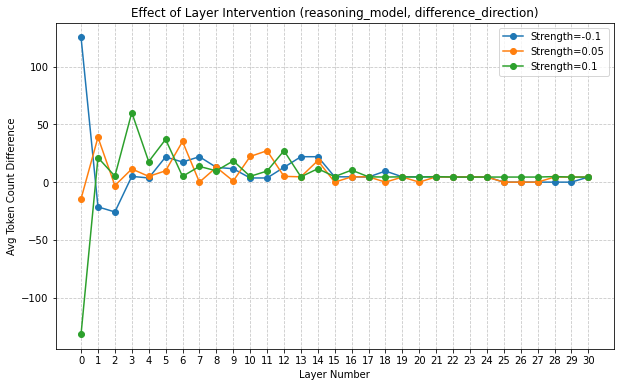

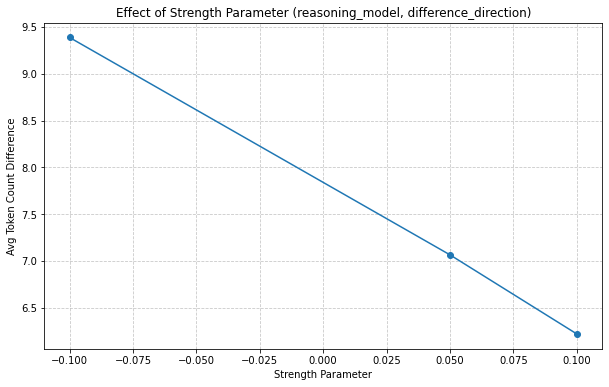

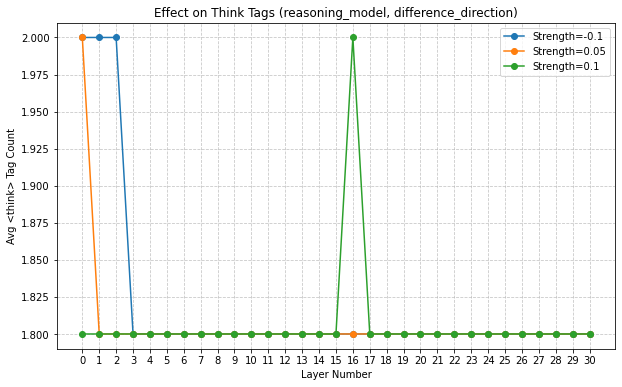

In [87]:
for direction_type, results_df in results_reasoning.items():
    direction_type_str = f"{direction_type}_direction"
    plot_layer_token_counts(results_df, 'reasoning_model', direction_type_str)
    plot_strength_token_counts(results_df, 'reasoning_model', direction_type_str)
    plot_reasoning_metrics(results_df, 'reasoning_model', direction_type_str)

In [ ]:
from reasoning_enhancement import *

In [57]:
orthogonalized_model = apply_orthogonalization(model_reasoning,
                activations_scored['reasoning'][30],
                strength=0.1)

100%|██████████| 32/32 [00:00<00:00, 3921.40it/s]


In [58]:
# Test on a few examples
N_TEST_EXAMPLES = 10
print(f"Testing on {N_TEST_EXAMPLES} examples from the test set")

for i in range(N_TEST_EXAMPLES):
    test_prompt = toy_math_problems[i]
    print(f"\n\n--- EXAMPLE {i+1} ---")
    print(f"PROBLEM:\n{test_prompt}")
    
    # Tokenize the test prompt
    test_tokens = tokenize_instructions(
        model_original.tokenizer, 
        [test_prompt], 
        CHAT_TEMPLATE
    )
    
    # Generate baseline response (without reasoning enhancement)
    baseline_response = generate_with_hooks(orthogonalized_model,
                                            test_tokens,
                                            temperature=0.0,
                                            max_tokens_generated=250)
    print("\nORTHOGONALIZED RESPONSE:")
    print(baseline_response[0])

Testing on 10 examples from the test set


--- EXAMPLE 1 ---
PROBLEM:
What is 2+2?

ORTHOGONALIZED RESPONSE:

</think>

</think>

2 + 2 equals 4.


--- EXAMPLE 2 ---
PROBLEM:
What is 5*7?

ORTHOGONALIZED RESPONSE:

</think>
首先，我需要计算5乘以7的结果。

5乘以7等于35。

因此，最终答案是35。
</think>

好的，下面是关于计算 \(5 \times 7\) 的详细步骤：

**步骤 1：写出算式**
\[
5 \times 7
\]

**步骤 2：进行乘法运算**
\[
5 \times 7 = 35
\]

**最终答案：**
\[
\boxed{35}
\]


--- EXAMPLE 3 ---
PROBLEM:
If x=3 and y=4, what is x+y?

ORTHOGONALIZED RESPONSE:
<think>
首先，我需要理解用户的问题。用户提供了两个数值，x=3和y=4，要求计算x加y的和。

接下来，我会回顾加法的基本概念，确认加法运算的规则。

然后，我会将x和y的值代入加法运算中，计算3加4的结果。

最后，我会得出结论，x加y等于7。
</think>

**解题过程：**

我们需要计算 \( x + y \) 的值，其中已知 \( x = 3 \) 和 \( y = 4 \)。

步骤如下：

1. **代入已知值：**
   \[
   x + y = 3 + 4
   \]

2. **进行加法运算：**
   \[
   3 + 4 = 7
   \]

**最终答案：**
\[
\boxed{7}
\]


--- EXAMPLE 4 ---
PROBLEM:
What is the square root of 16?

ORTHOGONALIZED RESPONSE:
不用了，用户已经说了他不想用了。好的，用户现在想知道√16是多少。嗯，√16是4，对吧？不过，我得确认一下。嗯，4乘以4等于16，没错。所以，答案应该是4。
</think><think>
首先，我需要